#### Подключение библиотек и скриптов

In [2235]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import random

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.neighbors import KNeighborsClassifier


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

In [2236]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [2237]:
def evaluate_preds(model, X_train, X_val, y_train, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    get_classification_report(y_train, y_train_pred, y_val, y_val_pred)

In [2238]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [2239]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [2240]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [2241]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote', 'combination'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)
        
    elif method == 'combination':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], int(target_counts[minor_class_name]*2))
        ], ignore_index=True)

        disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

#### Пути к директориям и файлам

In [2242]:
DATA_ROOT = Path('./data/course project/')
MODELS_PATH = Path('./models/')

# input
TRAIN_DATASET_PATH = DATA_ROOT / 'course_project_train.csv'
PREP_DATASET_PATH = DATA_ROOT / 'training_project_data_prep.csv'

# output
TRAIN_FULL_PATH = 'training_project_train_full.csv'
TRAIN_PART_PATH = 'training_project_train_part_b.csv'
TEST_PART_PATH = 'training_project_test_part.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

#test
TEST_DATASET_PATH = DATA_ROOT / 'course_project_test.csv'

### Загрузка данных

In [2243]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [2244]:
train_df.shape

(7500, 17)

In [2245]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [2246]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [2247]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

Числовые в строковые переводить не нужно.
Можно поменять тип числовых для экономии памяти.
После изучения отдельных признаков тип некоторых категориальных переменных можно привести к числовым.

In [2248]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Обзор данных
#### Обзор целевой переменной

In [2249]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Наблюдаем дисбаланс классов. Необходимо будет скорректировать.

#### Обзор количественных признаков

In [2250]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Есть неадекватные значения в признаке "Credit Score".
В некоторых признаках среднее значение смещено по сравнению с медианой.

#### Обзор номинативных признаков

In [2251]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**Home Ownership**: Have Mortgage и Home Mortgage вероятно значат одно и то же, можно объединить; можно преобразовать в дамми переменные <br>
**Years in a current job**: преобразуем в числовой тип данных после заполнения пропусков <br>
**Purpose**: можно посмотреть распределение целевой переменной и объединить классы, затем преобразовать в дамми переменные <br>
**Term**: можно преобразовать в 1/0 и тип int

### Обработка пропусков

In [2252]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

**Annual income**: пропуски можно заполнить модой, но лучше - обучить модель для заполнения пропусков<br>
**Years in current job**: будем считать, что пропуск - значит человек сейчас не работает; заполняем нулями<br>
**Months since last delinquent**: очень много пропусков. надо обучать модель для их заполнения пропусков или не использовать признак вообще<br>
**Bankruptcies**: пропусков мало; будем считать что NaN - отсутствие банкротства, приравниваем к нулю<br>
**Credit score**: вообще-то рассчитывается банками => мы можем тоже рассчитать с помощью модели; упрощённо - заменим модой<br>

### Обработка выбросов, заполнение пропусков

In [2253]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
                      'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                      'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount',
                      'Current Credit Balance', 'Monthly Debt', 'Credit Score']

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts',
                      'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                      'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
                      'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

#### Числовые признаки

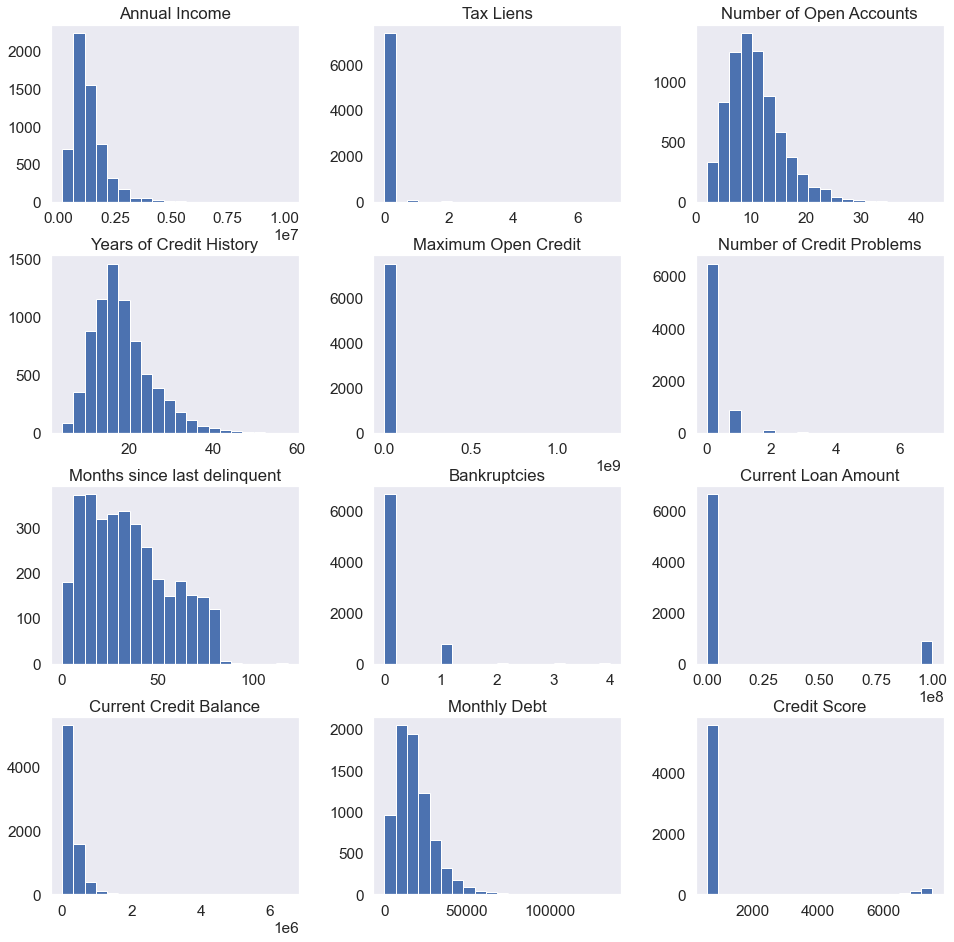

In [2254]:
train_df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

В признаке "Annual Income" достаточно много пропусков и большой хвост на графике распределения. Если заполнить пропуски и выбросы медианой, получится очень много одинаковых значений. Поэтому заполняем рандомными значениями из диапазона от min до max с учётом выбросов (учитываем по квантилю 0.975)

UPD: Метрики получаются лучше, если данные не обрезать, просто заполнить пропуски

In [2255]:
# condition_AI = (df['Annual Income'] > df['Annual Income'].quantile(.975)) | (df['Annual Income'].isna())
# annual_income_outliers = df.loc[condition_AI].index
# max_income = df.loc[~ condition_AI, ['Annual Income']].max()
# min_income = df.loc[~ condition_AI, ['Annual Income']].min()
# for x in annual_income_outliers:
#     df.loc[x, 'Annual Income'] = random.randint(int(min_income), int(max_income))

In [2256]:
condition_AI = train_df['Annual Income'].isna()
annual_income_outliers = train_df.loc[condition_AI].index
max_income = train_df.loc[~ condition_AI, ['Annual Income']].max()
min_income = train_df.loc[~ condition_AI, ['Annual Income']].min()
for x in annual_income_outliers:
    train_df.loc[x, 'Annual Income'] = random.randint(int(min_income), int(max_income))

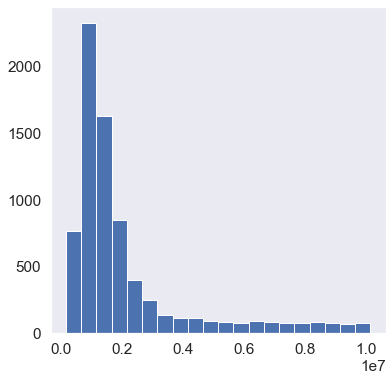

In [2257]:
train_df['Annual Income'].hist(figsize=(6, 6), bins=20, grid=False);

Убираем выбросы в признаках "Number of Open Accounts", "Years of Credit History", "Monthly Debt" по квантилю 0.99

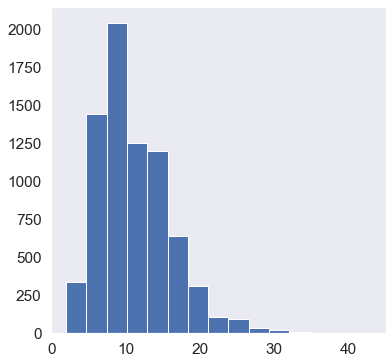

In [2258]:
train_df['Number of Open Accounts'].hist(figsize=(6, 6), bins=15, grid=False);

In [2259]:
train_df.loc[train_df['Number of Open Accounts'] > train_df['Number of Open Accounts'].quantile(.99), 'Number of Open Accounts'] = train_df['Number of Open Accounts'].median()

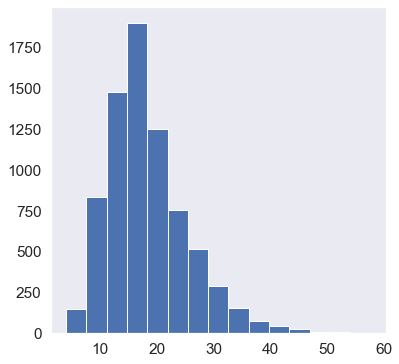

In [2260]:
train_df['Years of Credit History'].hist(figsize=(6, 6), bins=15, grid=False);

In [2261]:
train_df.loc[train_df['Years of Credit History'] > train_df['Years of Credit History'].quantile(.99), 'Years of Credit History'] = train_df['Years of Credit History'].median()

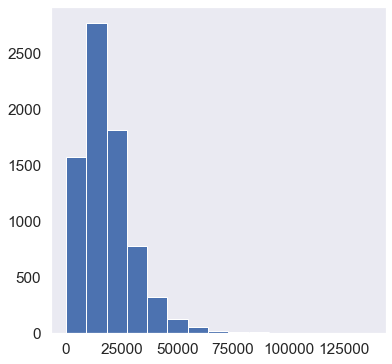

In [2262]:
train_df['Monthly Debt'].hist(figsize=(6, 6), bins=15, grid=False);

In [2263]:
train_df.loc[train_df['Monthly Debt'] > train_df['Monthly Debt'].quantile(.99), 'Monthly Debt'] = train_df['Monthly Debt'].median()

В признаке "Credit Score" много неадекватных значений (максимальное значение Кредит Скор вообще 850, а минимальное - 300).
Если посмотреть на график распределения значений, которые меньше 850, можно отметить, что оно далеко не является нормальным. Т.е. некорректно заполнять пропуски и выбросы медианой. Если заполнить их модой, появится много одинаковых значений. Поэтому заполняем их рандомными значениями от min до max с учетом выбросов.

Также приведём значения признака к типу int, т.к. они целочисленные по факту.

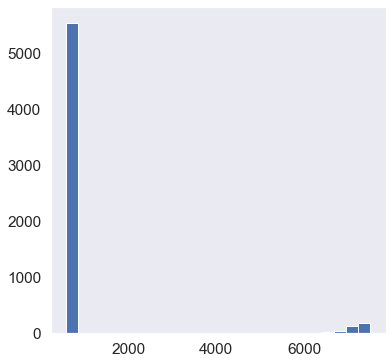

In [2264]:
train_df['Credit Score'].hist(figsize=(6, 6), bins=25, grid=False);

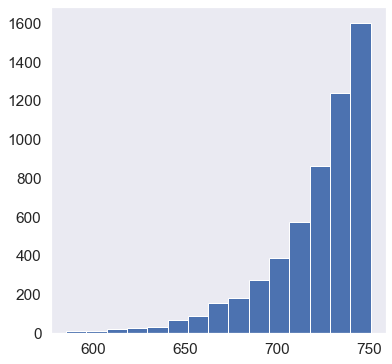

In [2265]:
train_df.loc[train_df['Credit Score'] < 850, 'Credit Score'].hist(figsize=(6, 6), bins=15, grid=False);

In [2266]:
max_credit_score = train_df.loc[df['Credit Score'] < 850, 'Credit Score'].max()
min_credit_score = train_df.loc[df['Credit Score'] > 300, 'Credit Score'].min()
condition_CS = (train_df['Credit Score'] > 850) | (train_df['Credit Score'] < 300) | (train_df['Credit Score'].isna())
credit_score_outliers = train_df.loc[condition_CS].index
for x in credit_score_outliers:
    train_df.loc[x, 'Credit Score'] = random.randint(min_credit_score, max_credit_score)

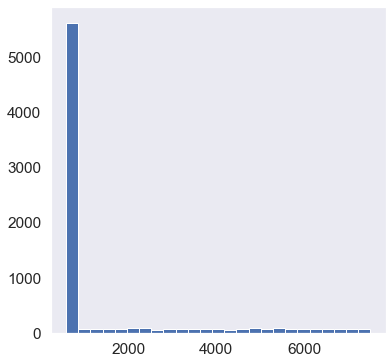

In [2267]:
train_df['Credit Score'].hist(figsize=(6, 6), bins=25, grid=False);

In [2268]:
train_df['Credit Score'] = train_df['Credit Score'].astype(int)

В признаке "Bankruptcies" пропуски заполним нулями: считаем, что раз там пропуск, значит банкротств нет.

In [2269]:
train_df.loc[df['Bankruptcies'].isna() , 'Bankruptcies'] = 0

Заполняем выбросы в признаке Current Loan

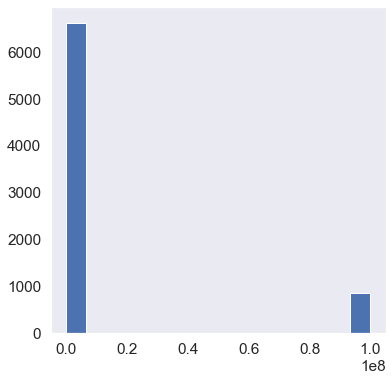

In [2270]:
train_df['Current Loan Amount'].hist(figsize=(6, 6), bins=15, grid=False);

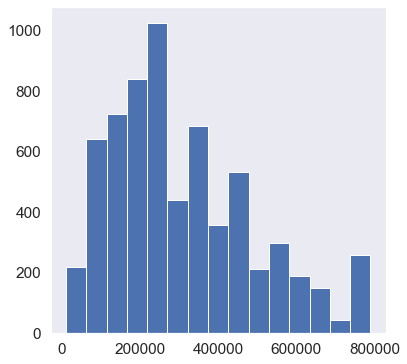

In [2271]:
train_df.loc[train_df['Current Loan Amount'] < 99999999, 'Current Loan Amount'].hist(figsize=(6, 6), bins=15, grid=False);

In [2272]:
train_df.loc[df['Current Loan Amount'] > 1000000, 'Current Loan Amount'] = train_df['Current Loan Amount'].median()

#### Категориальные признаки

In [2273]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Приведём признак "Years in current job" к числовому типу. Чем дольше человек работает на работе, тем меньше вероятность, что его уволят и он останется без денег, поэтому не обязательно его оставлять категориальным.
Значений в категории "<1" достаточно много, что отнести их к классу "1". И также некорректно присваивать им значение "0", т.к. человек всё-таки работает. Поэтому присвоим значение 0.5, а пропуски заполним нулями.

In [2274]:
train_df['Years in current job'] = train_df['Years in current job'].map({'10+ years':'10','2 years':'2','3 years':'3','< 1 year':'0.5','5 years':'5','1 year':'1','4 years':'4',
                       '6 years':'6','7 years':'7','8 years':'8','9 years':'9'})
train_df.loc[train_df['Years in current job'].isna() , 'Years in current job'] = 0
train_df['Years in current job'] = train_df['Years in current job'].astype(float)

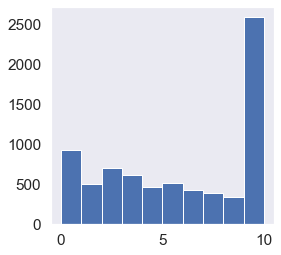

In [2275]:
train_df['Years in current job'].hist(figsize=(4, 4), grid=False);

В признаке "Term" два значения, можно заменить бинарной переменной. Пропуски заполнить рандомными значениями, привести к типу int.

In [2276]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [2277]:
train_df['Term'] = train_df['Term'].map({'Short Term':'0','Long Term':'1'})

In [2278]:
train_df.loc[train_df['Term'].isna() , 'Term'] = random.randint(0,1)

In [2279]:
train_df['Term'] = train_df['Term'].astype(int)

В признаке "Home Ownership" вероятно равны по смыслу значения "Have Mortgage" и "Home Mortgage". К тому же значений "Have Mortgage" мало, поэтому переименуем их в "Home Mortgage" и заменим на дамми переменные.

К дамми переменным можно привести и признак Purpose, но там довольно много значений. Возможно, некоторые из них можно объединить после статистического анализа.

In [2280]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [2281]:
train_df.loc[train_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [2282]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'], prefix='Home Ownership')], axis=1)

In [2283]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
Credit Default                     0
Home Ownership_Home Mortgage       0
Home Ownership_Own Home            0
Home Ownership_Rent                0
dtype: int64

Пропусков в признаке "Months since last delinquent" больше половины. Поэтому заполнять их не будем. Признак просто не будет использоваться при построении модели.

In [2284]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   int32  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Оформление препроцессинга в класс

In [2285]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.max_income = X['Annual Income'].max()
        self.min_income = X['Annual Income'].min()
        self.medians = X.median()
        self.quantiles = X.quantile(.99)
        self.max_cs = X.loc[X['Credit Score'] < 850, 'Credit Score'].max()
        self.min_cs = X.loc[X['Credit Score'] > 300, 'Credit Score'].min()
#         self.number_of_open_accounts_quantile = X['Number of Open Accounts'].quantile(.99)
    
    def transform(self, X):
        """Трансформация данных"""

        # Annual Income
        annual_income_outliers = X.loc[X['Annual Income'].isna()].index
        for i in annual_income_outliers:
            X.loc[i, 'Annual Income'] = random.randint(int(self.min_income), int(self.max_income))
                
        #Number of Open Accounts
        X.loc[X['Number of Open Accounts'] > self.quantiles['Number of Open Accounts'],
              'Number of Open Accounts'] = self.medians['Number of Open Accounts']
        
        # Years of Credit History
        X.loc[X['Years of Credit History'] > self.quantiles['Years of Credit History'],
              'Years of Credit History'] = self.medians['Years of Credit History']
       
        # Monthly Debt
        X.loc[X['Monthly Debt'] > self.quantiles['Monthly Debt'],
              'Monthly Debt'] = self.medians['Monthly Debt']
        
        # LifeSquare
        X['Credit_Score_outlier'] = 0
        condition_CS = (X['Credit Score'] > 850) | (X['Credit Score'] < 300) | (X['Credit Score'].isna())
        X.loc[condition_CS, 'Credit_Score_outlier'] = 1
        
        credit_score_outliers = X.loc[condition_CS].index
        for i in credit_score_outliers:
            X.loc[i, 'Credit Score'] = random.randint(self.min_cs, self.max_cs)        
        
        # Bankrupties
        
        X.loc[X['Bankruptcies'].isna() , 'Bankruptcies'] = 0
        
        # Current Loan Amount
        
        X.loc[X['Current Loan Amount'] > 1000000 , 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        # Years in Current Job
        X['Years in current job'] = X['Years in current job'].map({'10+ years':'10','2 years':'2','3 years':'3','< 1 year':'0.5','5 years':'5','1 year':'1','4 years':'4',
                       '6 years':'6','7 years':'7','8 years':'8','9 years':'9'})
        X.loc[X['Years in current job'].isna() , 'Years in current job'] = 0
        X['Years in current job'] = X['Years in current job'].astype(float)
        
        # Term
        
        X['Term'] = X['Term'].map({'Short Term':'0','Long Term':'1'})
        X.loc[X['Term'].isna() , 'Term'] = random.randint(0,1)
        X['Term'] = X['Term'].astype(int)
        
        # Home Ownership
        
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'], prefix='Home Ownership')], axis=1)
        
       
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Анализ корреляций

#### Корреляция признаков с целевым

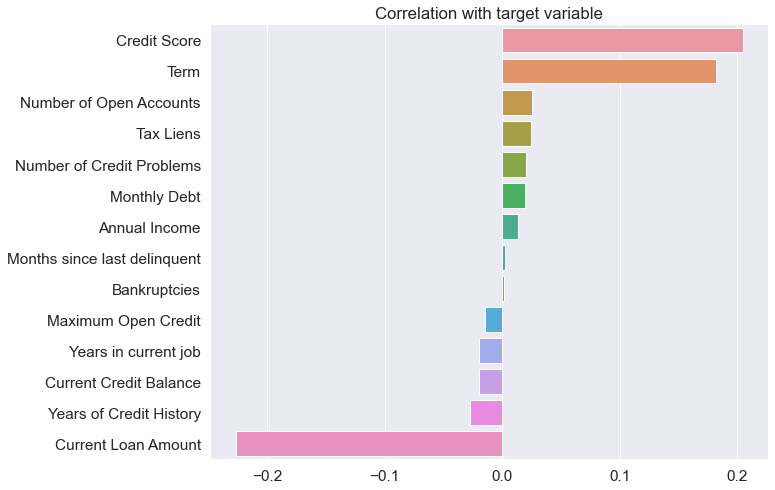

In [2286]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Признак "Months since last delinquent" закономерно некоррелирует с целевой переменной: он почти полностью состоит из пропусков.
Отметим, что "Bankruptcies" так же с "Credit Default" Не коррелирует.

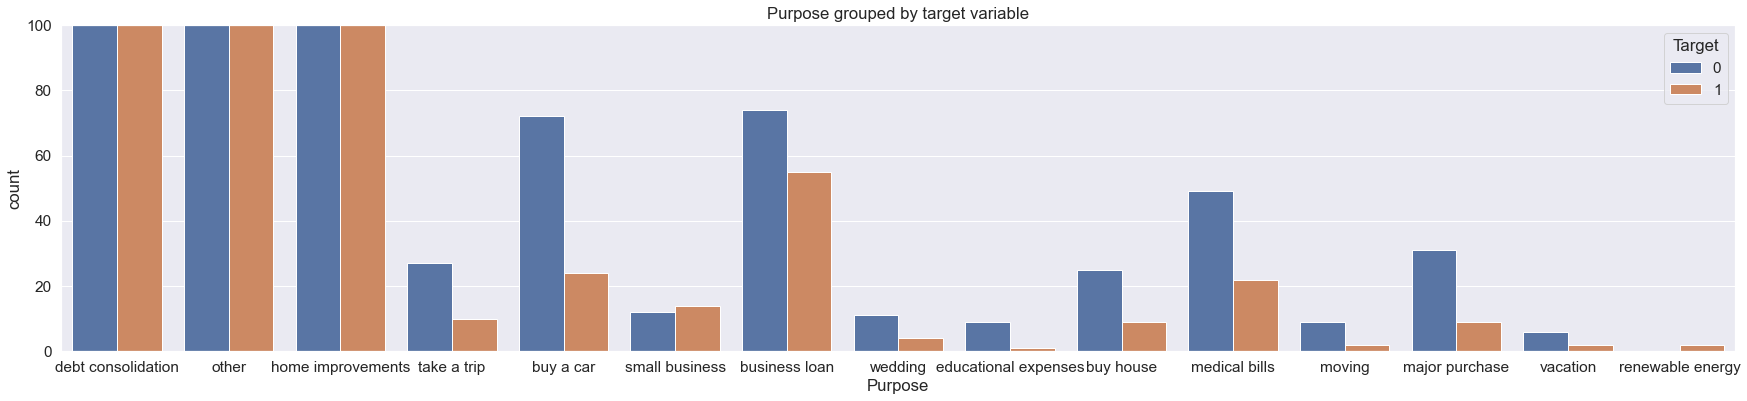

In [2287]:
plt.figure(figsize=(30, 6))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.ylim(0,100)

plt.show()

Есть вероятность, что некоторые значения признака "Purpose" вносят приблизительно одинаковый вклад в значение целевой переменной, т.е. распределение по целевой переменной будет схожее. Проверим эту гипотезу с помощью статистического теста. Например, критерия согласия Пирсона (хи квадрат). Метод непараметрический, поэтому нет необходимости проверять нормальность распределения.

In [2288]:
train_df['ID'] = train_df.index

In [2289]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['home improvements', 'buy a car']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.9084708624865527

In [2290]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['home improvements', 'major purchase']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.7467740513733911

In [2291]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['home improvements', 'take a trip']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

1.0

In [2292]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['home improvements', 'wedding']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

1.0

In [2293]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['home improvements', 'vacation']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

1.0

In [2294]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['home improvements', 'educational expenses']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.42845295138233785

In [2295]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['home improvements', 'debt consolidation']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.5154852485989191

In [2296]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['home improvements', 'other']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.2552281402751723

In [2297]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['home improvements', 'buy house']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

1.0

In [2298]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['home improvements', 'medical bills']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.48861246107260037

In [2299]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['home improvements', 'moving']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.8017458016217485

In [2300]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['small business', 'business loan']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.40483403834216214

In [2301]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['small business', 'renewable energy']), ['ID','Purpose', 'Credit Default']]
table = purpose_and_target_s.pivot_table(index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

nan

Объединим в группы такие значения признака, между распределениями по целевой переменной которых нет статистически значимых различий (т.е. р > 0.05).

In [2302]:
train_df['Purpose_cat'] = 'C'

In [2303]:
train_df.loc[train_df['Purpose'].isin(['debt consolidation', 'other', 'home improvements',
                           'take a trip', 'buy a car', 'wedding', 'educational expenses',
                           'buy house', 'medical bills', 'moving', 'major purchase','vacation']), 'Purpose_cat'] = 'A'

In [2304]:
train_df.loc[train_df['Purpose'].isin(['small business', 'business loan']), 'Purpose_cat'] = 'B'

In [2305]:
train_df['Purpose_cat'].value_counts()

A    7343
B     155
C       2
Name: Purpose_cat, dtype: int64

In [2306]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Purpose_cat'], prefix='Purpose_cat')], axis=1)

Оценим корреляцию признаков между собой.

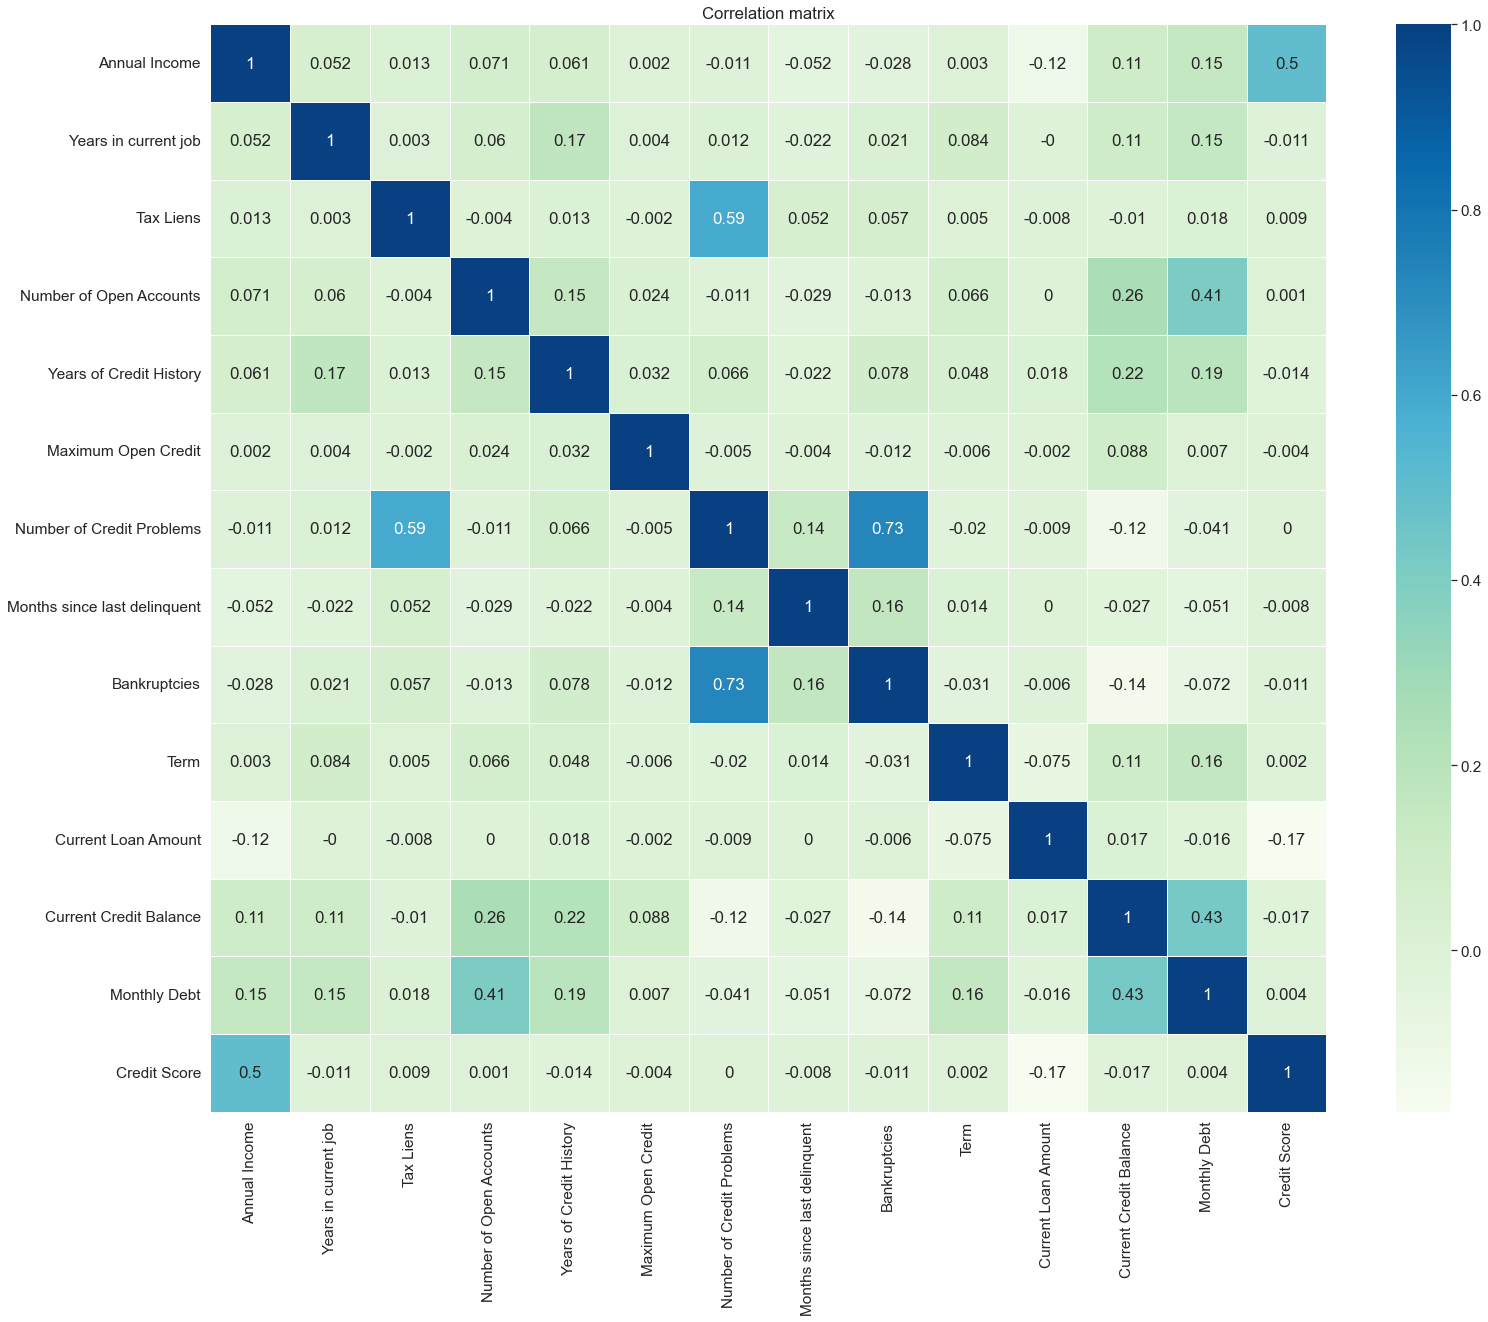

In [2307]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(train_df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

"Bankruptcies" слабо коррелирует с целевой переменной, при этом замечена существенная корреляция с признаком "Number of Credit Problems". Поэтому признак "Bankruptcies" можно не использовать

### Генерация новых признаков

По идее, чем меньше человеку осталось платить кредит, тем вероятнее он его всё-таки выплатит и будет в целом платежеспособным. Введём признак 'Left Credit Term':

In [2308]:
train_df['Left Credit Term'] = 0

In [2309]:
train_df.loc[train_df['Monthly Debt'] != 0, 'Left Credit Term'] = train_df['Current Loan Amount'] / train_df['Monthly Debt']

Учтём, что ипотеки дают максимум на 100 лет (1200 месяцев), и обработаем выбросы.

In [2310]:
train_df.loc[df['Left Credit Term'] > 1200, 'Left Credit Term'] = train_df['Left Credit Term'].median()

Введём признак платежеспособности: вычтем из годового дохода месячный долг, умноженный на 12

In [2311]:
train_df['Solvency'] = train_df['Annual Income'] - 12 * train_df['Monthly Debt']

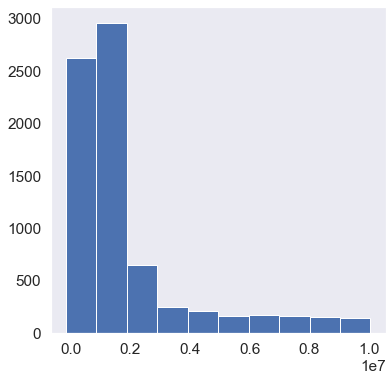

In [2312]:
train_df['Solvency'].hist(figsize=(6, 6), grid=False);

Введём признак, обозначающий "коэффициент ненадёжности" клиента. Т.е. кол-во проблем с кредитом+банкротства, делённое на кол-во открытых счетов. Если открытых счетов - 0, присвоим коэффициент 0.5 (50% надежности)

In [2313]:
train_df['Unreliability'] = 0.5
train_df.loc[train_df['Number of Open Accounts'] != 0, 'Unreliability'] = (train_df['Bankruptcies'] + train_df['Number of Credit Problems']) / train_df['Number of Open Accounts']
train_df.loc[train_df['Unreliability'] > 1, 'Unreliability'] = 0.5

### Оформление генерации новых фич в класс

In [2314]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.default_by_home_ownership = None
        self.default_by_home_ownership_median = None
        self.train_income_max = None
        self.credit_default_by_income = None
        self.credit_default_by_income_median = None
        
        
    def income_to_cat(self, X):
        bins = [0, 1000000, 2000000, 4000000, self.train_income_max]
        X['income_cat'] = pd.cut(X['Annual Income'], bins=bins, labels=False)
    
        X['income_cat'].fillna(-1, inplace=True)
        return X
    
    def fit(self, X, y=None):
        
        X = X.copy()
            
        # Target encoding
        ## Home Ownership
        df = X.copy()
        
        if y is not None:
            df['Credit Default'] = y.values
            self.default_by_home_ownership = df.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Credit Default']].rename(columns={
                        'Credit Default': 'target_encode_home_ownership'
                        })
                                          
            self.default_by_home_ownership_median = self.default_by_home_ownership['target_encode_home_ownership'].median()
            
        ## Annual Income
        if y is not None:
            self.train_income_max = df['Annual Income'].max()
            df['Credit Default'] = y.values
            df = self.income_to_cat(df)
            self.credit_default_by_income = df.groupby(['income_cat'], as_index=False).agg({'Credit Default':'mean'}).\
                                            rename(columns={'Credit Default':'Credit Default By Income'})
            self.credit_default_by_income_median = self.credit_default_by_income['Credit Default By Income'].median()
        

        
    def transform(self, X):
        
        #Purpose_cat
        X['Purpose_cat'] = 'C'
        X.loc[X['Purpose'].isin(['debt consolidation', 'other', 'home improvements',
                           'take a trip', 'buy a car', 'wedding', 'educational expenses',
                           'buy house', 'medical bills', 'moving', 'major purchase','vacation']), 'Purpose_cat'] = 'A'
        X.loc[X['Purpose'].isin(['small business', 'business loan']), 'Purpose_cat'] = 'B'
        
        X = pd.concat([X, pd.get_dummies(X['Purpose_cat'], prefix='Purpose_cat')], axis=1)
       
        #Left Credit Term
        X['Left Credit Term'] = 0
        X.loc[X['Monthly Debt'] != 0, 'Left Credit Term'] = X['Current Loan Amount'] / X['Monthly Debt']
        X.loc[X['Left Credit Term'] > 1200, 'Left Credit Term'] = X['Left Credit Term'].median()
        
        #Solvency
        X['Solvency'] = X['Annual Income'] - 12 * X['Monthly Debt']
    
        #Unreliability
        X['Unreliability'] = 0.5
        X.loc[X['Number of Open Accounts'] != 0, 'Unreliability'] = (X['Bankruptcies'] + X['Number of Credit Problems']) / X['Number of Open Accounts']
        X.loc[X['Unreliability'] > 1, 'Unreliability'] = 0.5
    
            
        # More categorical features
        X = self.income_to_cat(X)  # + столбец income_cat
      
        # Target encoding
        if self.default_by_home_ownership is not None:
            X = X.merge(self.default_by_home_ownership, on=['Home Ownership'], how='left')
            X['target_encode_home_ownership'].fillna(self.default_by_home_ownership_median, inplace=True)
            
        if self.credit_default_by_income is not None:
            X = X.merge(self.credit_default_by_income, on=['income_cat'], how='left')
            X['Credit Default By Income'].fillna(self.credit_default_by_income_median, inplace=True)
            
        if 'Purpose_cat_C' not in X:
            X['Purpose_cat_C'] = 0
        
        return X

Выбираем признаки, по которым будем строить модель.

In [2315]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'ID',
 'Purpose_cat',
 'Purpose_cat_A',
 'Purpose_cat_B',
 'Purpose_cat_C',
 'Left Credit Term',
 'Solvency',
 'Unreliability']

In [2316]:
TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 
                     'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Current Loan Amount',
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score',
                     'Left Credit Term', 'Solvency', 'Unreliability', 'Term', 'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
                     'Home Ownership_Rent', 'Purpose_cat_A', 'Purpose_cat_B']

CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Purpose_cat']

In [2317]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=TARGET_NAME)
y = train_df[TARGET_NAME]

Подготовим данные из датасетов для обучения и теста:

In [2318]:
preprocessor = DataPreprocessing()
preprocessor.fit(X)

X = preprocessor.transform(X)
test_df = preprocessor.transform(test_df)

X.shape, test_df.shape

((7500, 20), (2500, 20))

Сгенерируем новые признаки:

In [2319]:
features_gen = FeatureGenerator()
features_gen.fit(X, y)

X = features_gen.transform(X)
test_df = features_gen.transform(test_df)

X.shape, test_df.shape

((7500, 30), (2500, 30))

Проведём нормализацию значений признаков:

In [2320]:
scaler = StandardScaler()

X_norm = X.copy()
X_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(X_norm[NUM_FEATURE_NAMES])

X = X_norm.copy()

test_df_norm = test_df.copy()
test_df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(test_df_norm[NUM_FEATURE_NAMES])

test_df = test_df_norm.copy()

Разделим датасет на два: для обучения и валидации:

In [2321]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=26, stratify=y)

In [2322]:
X_train.shape, X_valid.shape, test_df.shape

((5025, 30), (2475, 30), (2500, 30))

Сохраним полученные датасеты без балансировки для модели CatBoost. Для остальных датасетов проведём балансировку по целевому признаку.
Было установлено, что с балансировкой методом андерсэмплинга метрики получаются лучше, чем при балансировке другими методами.

In [2323]:
X_train_cb = X_train
X_valid_cb = X_valid
y_train_cb = y_train
y_valid_cb = y_valid

In [2324]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, 'under')
    
df_balanced[TARGET_NAME].value_counts()

1    1416
0    1416
Name: Credit Default, dtype: int64

In [2325]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

Отберём только числовые данные для построения моделей:

In [2326]:
X_num = X_train[NUM_FEATURE_NAMES]
X_val = X_valid[NUM_FEATURE_NAMES]

Строим модель логистической регрессии. Метрики получаются в целом неплохие в сравнении с другими моделями. Модель не сильно переобучается.

In [2327]:
model_lr = LogisticRegression(C=0.01, max_iter=7)
model_lr.fit(X_num, y_train)

evaluate_preds(model_lr, X_num, X_val, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.60      0.66      0.63      1416
           1       0.62      0.56      0.59      1416

    accuracy                           0.61      2832
   macro avg       0.61      0.61      0.61      2832
weighted avg       0.61      0.61      0.61      2832

TEST

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1778
           1       0.45      0.59      0.51       697

    accuracy                           0.68      2475
   macro avg       0.63      0.65      0.63      2475
weighted avg       0.71      0.68      0.69      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1267  511
1                286  411


Модель К-ближайших соседей. Метрики так себе, сильное переобучение.

In [2328]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_num, y_train)

evaluate_preds(model_knn, X_num, X_val, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      1416
           1       0.75      0.68      0.72      1416

    accuracy                           0.73      2832
   macro avg       0.73      0.73      0.73      2832
weighted avg       0.73      0.73      0.73      2832

TEST

              precision    recall  f1-score   support

           0       0.78      0.57      0.66      1778
           1       0.35      0.59      0.44       697

    accuracy                           0.58      2475
   macro avg       0.57      0.58      0.55      2475
weighted avg       0.66      0.58      0.60      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1022  756
1                283  414


Модель Extreme Gradient Boosting. Метрики так себе, очень сильное переобучение без регуляризации.

In [2329]:
model_xgb = xgb.XGBClassifier(random_state=26)
model_xgb.fit(X_num, y_train)

evaluate_preds(model_xgb, X_num, X_val, y_train, y_valid)

[14:25:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1416
           1       1.00      1.00      1.00      1416

    accuracy                           1.00      2832
   macro avg       1.00      1.00      1.00      2832
weighted avg       1.00      1.00      1.00      2832

TEST

              precision    recall  f1-score   support

           0       0.82      0.56      0.67      1778
           1       0.38      0.69      0.49       697

    accuracy                           0.60      2475
   macro avg       0.60      0.63      0.58      2475
weighted avg       0.70      0.60      0.62      2475

CONFUSION MATRIX

col_0

Модель Light Gradient Boosting. Метрики неплохие, значительное переобучение.

In [2330]:
model_lgbm = lgbm.LGBMClassifier(random_state=26)
model_lgbm.fit(X_num, y_train)

evaluate_preds(model_lgbm, X_num, X_val, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1416
           1       0.98      0.98      0.98      1416

    accuracy                           0.98      2832
   macro avg       0.98      0.98      0.98      2832
weighted avg       0.98      0.98      0.98      2832

TEST

              precision    recall  f1-score   support

           0       0.83      0.56      0.67      1778
           1       0.39      0.71      0.50       697

    accuracy                           0.60      2475
   macro avg       0.61      0.63      0.59      2475
weighted avg       0.71      0.60      0.62      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1002  776
1                205  492


Модель CatBoost (только с числовыми сбалансированными данными, без регуляризации): метрики самые хорошие, значительное переобучение.

In [2331]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=26)
model_catb.fit(X_num, y_train)

evaluate_preds(model_catb, X_num, X_val, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1416
           1       0.90      0.92      0.91      1416

    accuracy                           0.91      2832
   macro avg       0.91      0.91      0.91      2832
weighted avg       0.91      0.91      0.91      2832

TEST

              precision    recall  f1-score   support

           0       0.84      0.59      0.69      1778
           1       0.40      0.70      0.51       697

    accuracy                           0.62      2475
   macro avg       0.62      0.65      0.60      2475
weighted avg       0.71      0.62      0.64      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1054  724
1                206  491


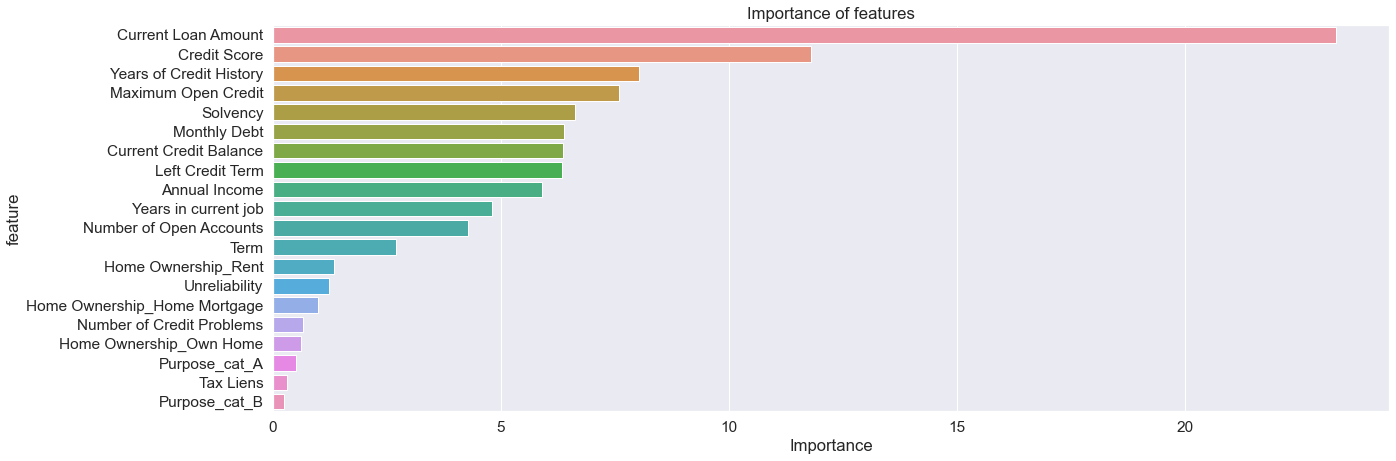

In [2332]:
important_features_top = show_feature_importances(X_num.columns,
                                                  model_catb.feature_importances_)

In [2333]:
feature_importances = pd.DataFrame(zip(X_num.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
7,Current Loan Amount,23.317745
10,Credit Score,11.810989
4,Years of Credit History,8.031680
5,Maximum Open Credit,7.595863
12,Solvency,6.629257
9,Monthly Debt,6.382289
8,Current Credit Balance,6.365406
11,Left Credit Term,6.343989
0,Annual Income,5.910660
1,Years in current job,4.804179


Было установлено, что признак Purpose_cat_C имеет практически нулевую важность, поэтому он не использовался при построении моделей.
Остальные признаки ок, нет признаков со слишком высокой важностью, все оставляем. Для снижения переобучения можно было бы часть убрать при необходимости.

## Финальная модель

Строим модель CatBoost без балансировки данных, но с указанием коэффициента дисбаланса. Используем категориальные признаки. Подберём гиперпараметры для снижения переобучения.

In [2334]:
target_counts = train_df['Credit Default'].value_counts()

major_class_name = target_counts.argmax()
minor_class_name = target_counts.argmin()

disbalance_coeff = target_counts[major_class_name] / target_counts[minor_class_name]
disbalance_coeff

2.549455750118315

In [2335]:
frozen_params = {
      'class_weights':[1, disbalance_coeff], 
     'silent':True,
     'random_state':26,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [2336]:
model_catb1 = catb.CatBoostClassifier(**frozen_params)
model_catb1.fit(X_train_cb, y_train_cb)

evaluate_preds(model_catb1, X_train_cb, X_valid_cb, y_train_cb, y_valid_cb)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      3609
           1       0.71      0.89      0.79      1416

    accuracy                           0.87      5025
   macro avg       0.83      0.87      0.85      5025
weighted avg       0.88      0.87      0.87      5025

TEST

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1778
           1       0.49      0.61      0.54       697

    accuracy                           0.71      2475
   macro avg       0.66      0.68      0.67      2475
weighted avg       0.73      0.71      0.72      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1333  445
1                271  426


In [2337]:
params = {'n_estimators':np.arange(130,170, 5),
          'max_depth':[5, 6, 7],
         'reg_lambda': np.linspace(4.5, 6, 20)}

In [2338]:
cv=StratifiedKFold(n_splits=5, random_state=26, shuffle=True)

Ниже подбор лучших гиперпараметров. Закомментирован т.к. занимает время.

In [2339]:
# %%time

# rs = RandomizedSearchCV(model_catb1, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(X_train_cb, y_train_cb)

In [2340]:
# rs.best_params_

In [2341]:
# rs.best_score_

In [2342]:
final_model = catb.CatBoostClassifier(**frozen_params, n_estimators=200,max_depth=6,reg_lambda=5.85)
final_model.fit(X_train_cb, y_train_cb)

evaluate_preds(final_model, X_train_cb, X_valid_cb, y_train_cb, y_valid_cb)


TRAIN

              precision    recall  f1-score   support

           0       0.87      0.73      0.80      3609
           1       0.51      0.71      0.60      1416

    accuracy                           0.73      5025
   macro avg       0.69      0.72      0.70      5025
weighted avg       0.77      0.73      0.74      5025

TEST

              precision    recall  f1-score   support

           0       0.85      0.73      0.78      1778
           1       0.49      0.66      0.56       697

    accuracy                           0.71      2475
   macro avg       0.67      0.70      0.67      2475
weighted avg       0.75      0.71      0.72      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1297  481
1                234  463


График ниже показывает, что достаточно примерно 2500 данных для достаточного обучения.

In [ ]:
show_learning_curve_plot(final_model, X_train_cb, y_train_cb)

In [ ]:
y_test_pred_probs = final_model.predict_proba(X_val_cb)
y_test_pred_probs

Из графиков ниже видно, что для лучшего разделения подходит отсечка 0.5 (стандартная по факту) и данные в целом разделяются с трудом, значительное пересечение.

*P.S. Для одной из моделей лучшая отсечка была на уровне 0.4, но я так и не разобралась, где можно задать эту отсечку :(*

In [ ]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_val_cb)

CatBoost была выбрана как лучшая модель. Переобучение удалось значительно снизить. Получалось снизить его почти до нуля, но в таком случае были хуже метрики на валидационном датасете.

Сохраняем модель

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

## Тестовый датасет

In [ ]:
test_df.shape

In [ ]:
test_df

In [ ]:
test_df.isna().sum()

In [ ]:
predictions = final_model.predict(test_df)
predictions

In [ ]:
len(predictions)

In [ ]:
preds = pd.DataFrame(predictions, columns = ['Credit Default'])

In [ ]:
preds

In [ ]:
preds.to_csv('AShelashen_predictions.csv', index=False)

# ----------------------------------------